# C-Value - Private Landed Property
The next bound:

1. Combine multiple data sources:
    1. HDB information from [Data.gov.sg](https://data.gov.sg/dataset/hdb-property-information)
    2. Condo information from www.data.com.sg (also scrape this)
    3. Square Foot API
2. Time Series

In [45]:
# Import required modules
import dns_property as dns
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import warnings

from numpy.random import seed
from lightgbm import LGBMRegressor
from os import listdir
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import RepeatedKFold, train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

# Settings
warnings.filterwarnings('ignore')

## Import Data

In [46]:
# Read data
df = pd.read_csv('../Data/caveat_data_final.csv')
df = df[df.category=='NonLanded']

# Preview
df.head()

,sn,project_name,street_name,type,postal_district,market_segment,tenure,type_of_sale,no_of_units,price,...,area_sqft,type_of_area,floor_level,target,date_of_sale,category,remaining_lease,freehold,age,floor
0,1,WALLICH RESIDENCE,WALLICH STREET,Apartment,2,CCR,99 yrs lease commencing from 2011,Resale,1.0,4300000.0,...,1313.0,Strata,51 to 55,3274.0,Aug-2019,NonLanded,91,0,8,55.0
1,2,QUEENS,STIRLING ROAD,Condominium,3,RCR,99 yrs lease commencing from 1998,Resale,1.0,1550000.0,...,1184.0,Strata,26 to 30,1309.0,Aug-2019,NonLanded,78,0,21,30.0
2,3,ONE PEARL BANK,PEARL BANK,Apartment,3,RCR,99 yrs lease commencing from 2019,New Sale,1.0,992000.0,...,431.0,Strata,01 to 05,2304.0,Aug-2019,NonLanded,99,0,0,5.0
3,4,ONE PEARL BANK,PEARL BANK,Apartment,3,RCR,99 yrs lease commencing from 2019,New Sale,1.0,1803000.0,...,700.0,Strata,16 to 20,2577.0,Aug-2019,NonLanded,99,0,0,20.0
4,5,SKY EVERTON,EVERTON ROAD,Apartment,2,RCR,Freehold,New Sale,1.0,2600000.0,...,1109.0,Strata,21 to 25,2345.0,Aug-2019,NonLanded,9999,1,34,25.0


## Feature Engineering

In [41]:
# Create month
df['mth'] = pd.to_datetime(df['date_of_sale'])

In [4]:
# # Generate month lags
# for var in ['type', 'market_segment', 'postal_district', 'street_name', 'project_name', 'freehold']:

#     df = dns.fe_mth(df, var, 1)
#     df = dns.fe_qtr(df, var, 1)

In [42]:
df.columns

Index(['sn', 'project_name', 'street_name', 'type', 'postal_district',
       'market_segment', 'tenure', 'type_of_sale', 'no_of_units', 'price',
       'nett_price', 'area_sqft', 'type_of_area', 'floor_level', 'target',
       'date_of_sale', 'category', 'remaining_lease', 'freehold', 'age',
       'floor', 'mth'],
      dtype='object')

## Conventional CV

In [43]:
# Private Vars
drop_vars_pri = ['sn', 'tenure', 'no_of_units', 'price', 'nett_price', 'floor_level', 'target', 'date_of_sale', 'category', 'mth']
vars_pri_bin = ['type', 'type_of_sale', 'type_of_area', 'market_segment', 'postal_district']

# Configure data
X_data = pd.get_dummies(df.drop(drop_vars_pri, axis=1),
                        columns=vars_pri_bin)
y_data = df['target']

# Configure CV
cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=100)

# Initialise models
lg = LGBMRegressor(n_estimators=100000, max_depth=20, random_state=123, n_jobs=4, reg_alpha=0.1, reg_lambda=0.9)
kn = KNeighborsRegressor(n_neighbors=10, weights='distance', n_jobs=4)

# Configure stop words
stop_words = [
    'road', 'avenue', 'street', 'drive', 'lorong', 'crescent', 'view', 'rise'
    'jalan', 'lane', 'walk', 'link', 'bukit',
    'rd', 'ave', 'st', 'dr', 'lor', 'cres', 'jln', 'pl'
]

### K-NN

In [44]:
kn_cv = dns.custom_cv(kn, X_data, y_data, cv, ['project_name', 'street_name'], stop_words, norm=True, ppd=True)

# ---- COMPUTING C-VALUE ---- #
Running iteration 1 of 5...
Running iteration 2 of 5...
Running iteration 3 of 5...
Running iteration 4 of 5...
Running iteration 5 of 5...

[MODEL STATISTICS]
M-PPD: 2.76%
PPD Deviation:
  +-5.0%: 69.36%
  +-10%: 87.63%
  +-20%: 97.37%

MAPE: 4.78%
MAE: $64
RMSE: $110
R2: 95.46%


### LightGBM

In [ ]:
lg_cv = dns.custom_cv(lg, X_data, y_data, cv, ['project_name', 'street_name'], stop_words, ppd=True)

# ---- COMPUTING C-VALUE ---- #
Running iteration 1 of 5...


## Step-Forward Testing

In [10]:
# Private Vars
drop_vars_pri = ['sn', 'tenure', 'no_of_units', 'price', 'nett_price', 'floor_level', 'target', 'date_of_sale', 'category']
vars_pri_bin = ['type', 'type_of_sale', 'type_of_area', 'market_segment', 'postal_district']

# Configure data
X_data = pd.get_dummies(df.drop(drop_vars_pri, axis=1),
                        columns=vars_pri_bin)
y_data = df['target']

# Configure CV
cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=100)

# Configure stop words
stop_words = [
    'road', 'avenue', 'street', 'drive', 'lorong', 'crescent', 'view', 'rise'
    'jalan', 'lane', 'walk', 'link', 'bukit',
    'rd', 'ave', 'st', 'dr', 'lor', 'cres', 'jln', 'pl'
]

### K-NN

# ---- COMPUTING C-VALUE ---- #
Running iteration 1 of 12...
Running iteration 2 of 12...
Running iteration 3 of 12...
Running iteration 4 of 12...
Running iteration 5 of 12...
Running iteration 6 of 12...
Running iteration 7 of 12...
Running iteration 8 of 12...
Running iteration 9 of 12...
Running iteration 10 of 12...
Running iteration 11 of 12...
Running iteration 12 of 12...



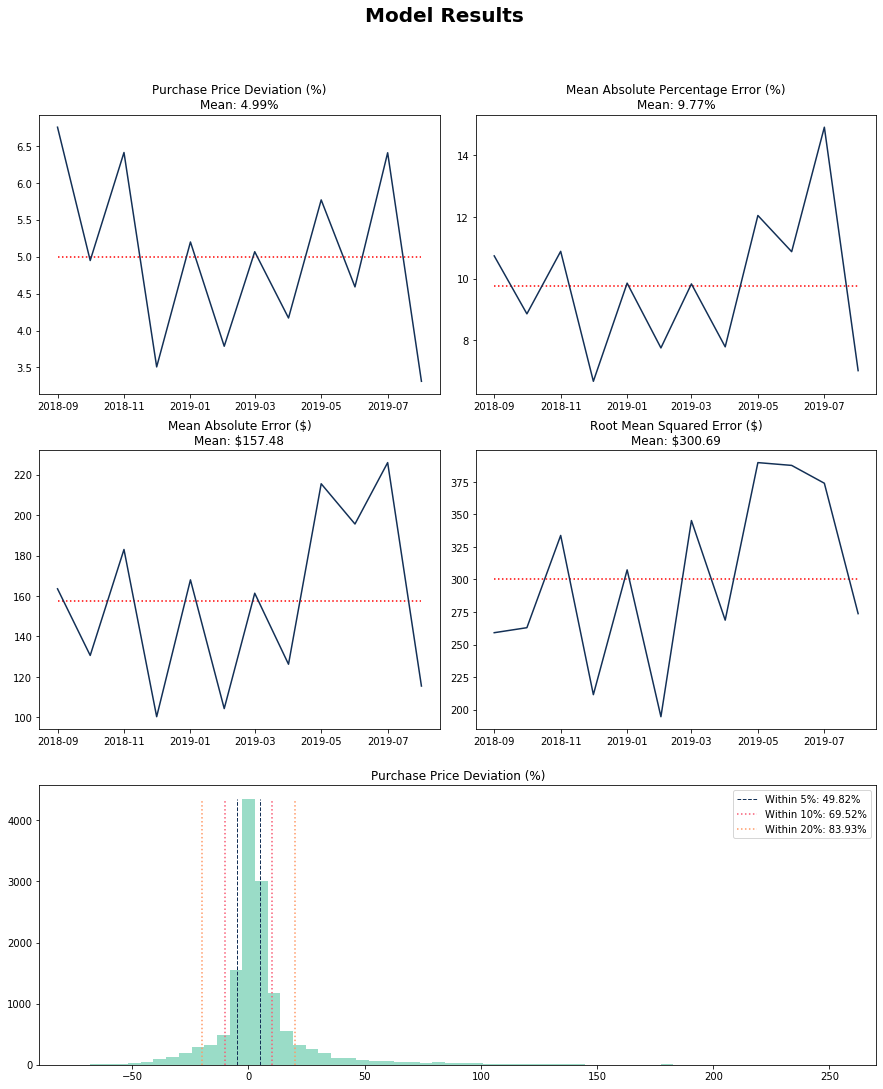

[MODEL STATISTICS]
M-PPD: 4.99%
PPD Deviation:
  +-5.0%: 51.63%
  +-10%: 71.39%
  +-20%: 85.48%

MAPE: 9.77%
MAE: $157
RMSE: $301
R2: 69.56%


In [11]:
kn = KNeighborsRegressor(n_neighbors=10, weights='distance', n_jobs=4)
kn_cv = dns.custom_ts(rgr=kn, X=X_data, y=y_data, timevar='mth', start='2018-09-01', tfidf_cols=['project_name', 'street_name'], stop_words=stop_words, dropout=0.1, ppd=True, random_state=100)

### LightGBM

# ---- COMPUTING C-VALUE ---- #
Running iteration 1 of 12...
Running iteration 2 of 12...
Running iteration 3 of 12...
Running iteration 4 of 12...
Running iteration 5 of 12...
Running iteration 6 of 12...
Running iteration 7 of 12...
Running iteration 8 of 12...
Running iteration 9 of 12...
Running iteration 10 of 12...
Running iteration 11 of 12...
Running iteration 12 of 12...



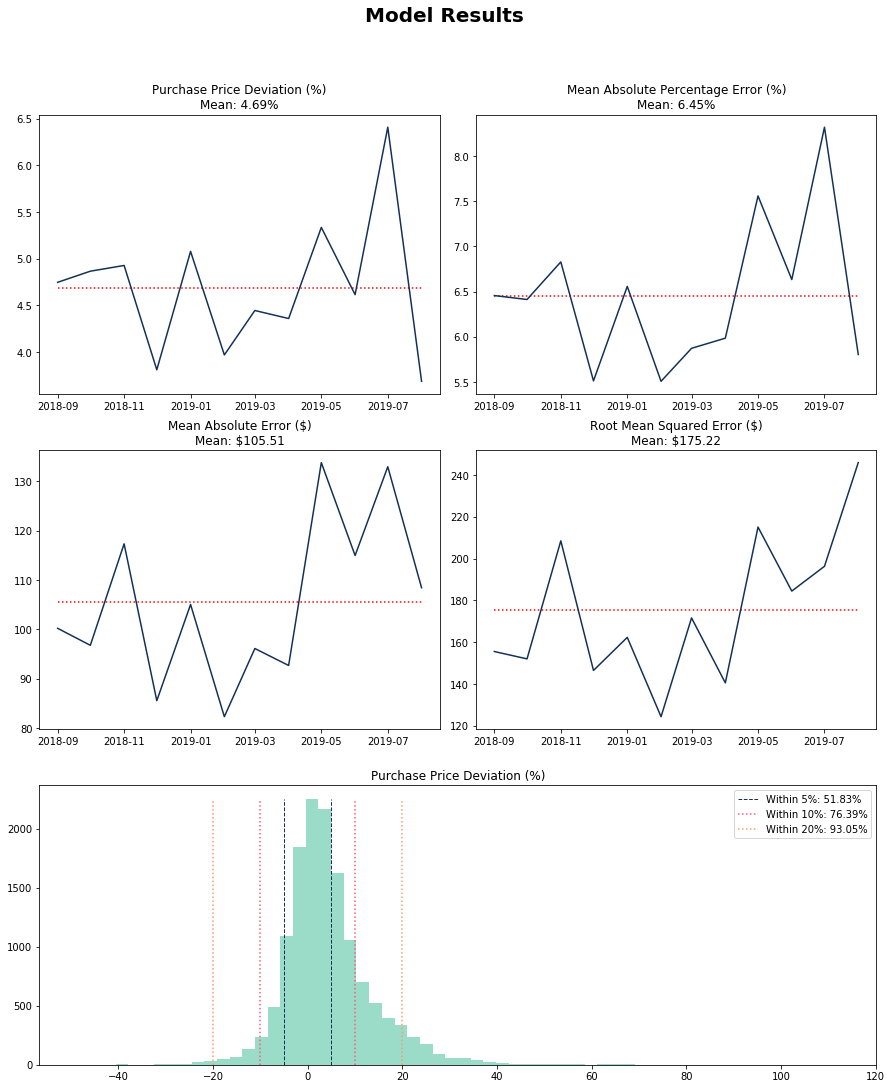

[MODEL STATISTICS]
M-PPD: 4.69%
PPD Deviation:
  +-5.0%: 53.36%
  +-10%: 77.94%
  +-20%: 93.78%

MAPE: 6.45%
MAE: $106
RMSE: $175
R2: 89.81%


In [12]:
lg = LGBMRegressor(n_estimators=1000, num_leaves=50, max_depth=10, random_state=123, n_jobs=4, reg_alpha=0.1, reg_lambda=0.9)
lg_cv = dns.custom_ts(rgr=lg, X=X_data, y=y_data, timevar='mth', start='2018-09-01', tfidf_cols=['project_name', 'street_name'], stop_words=stop_words, dropout=0.1, ppd=True, random_state=100)

## Step-Forward Testing with FE

In [17]:
# Private Vars
drop_vars_pri = ['sn', 'tenure', 'no_of_units', 'price', 'nett_price', 'floor_level', 'target', 'date_of_sale', 'category', 'mth_l', 'qtr', 'qtr_l']
vars_pri_bin = ['type', 'type_of_sale', 'type_of_area', 'market_segment', 'postal_district']

# Copy data
df2 = df.copy()

# Generate month lags
for var in ['type', 'market_segment', 'postal_district', 'street_name', 'project_name', 'freehold']:

    df2 = dns.fe_mth(df2, var, 1)
    df2 = dns.fe_qtr(df2, var, 1)

# Configure data
X_data = pd.get_dummies(df2.drop(drop_vars_pri, axis=1),
                        columns=vars_pri_bin)
y_data = df2['target']

# Configure CV
cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=100)

# Configure stop words
stop_words = [
    'road', 'avenue', 'street', 'drive', 'lorong', 'crescent', 'view', 'rise'
    'jalan', 'lane', 'walk', 'link', 'bukit',
    'rd', 'ave', 'st', 'dr', 'lor', 'cres', 'jln', 'pl'
]

### K-NN

# ---- COMPUTING C-VALUE ---- #
Running iteration 1 of 12...
Running iteration 2 of 12...
Running iteration 3 of 12...
Running iteration 4 of 12...
Running iteration 5 of 12...
Running iteration 6 of 12...
Running iteration 7 of 12...
Running iteration 8 of 12...
Running iteration 9 of 12...
Running iteration 10 of 12...
Running iteration 11 of 12...
Running iteration 12 of 12...



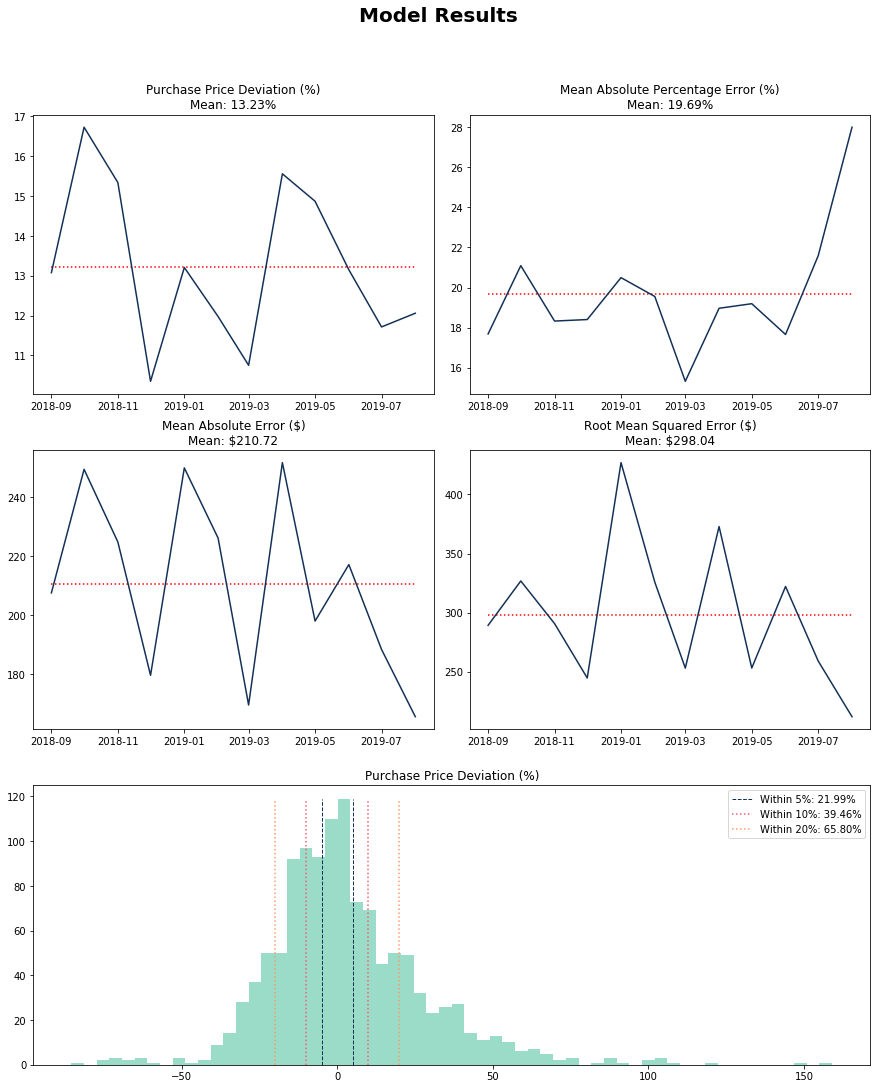

[MODEL STATISTICS]
M-PPD: 13.23%
PPD Deviation:
  +-5.0%: 22.33%
  +-10%: 39.86%
  +-20%: 66.28%

MAPE: 19.69%
MAE: $211
RMSE: $298
R2: 52.12%


In [18]:
kn = KNeighborsRegressor(n_neighbors=10, weights='distance', n_jobs=4)
kn_cv = dns.custom_ts(rgr=kn, X=X_data, y=y_data, timevar='mth', start='2018-09-01', tfidf_cols=['project_name', 'street_name'], stop_words=stop_words, dropout=0.1, ppd=True, random_state=100)

### LightGBM

# ---- COMPUTING C-VALUE ---- #
Running iteration 1 of 12...
Running iteration 2 of 12...
Running iteration 3 of 12...
Running iteration 4 of 12...
Running iteration 5 of 12...
Running iteration 6 of 12...
Running iteration 7 of 12...
Running iteration 8 of 12...
Running iteration 9 of 12...
Running iteration 10 of 12...
Running iteration 11 of 12...
Running iteration 12 of 12...



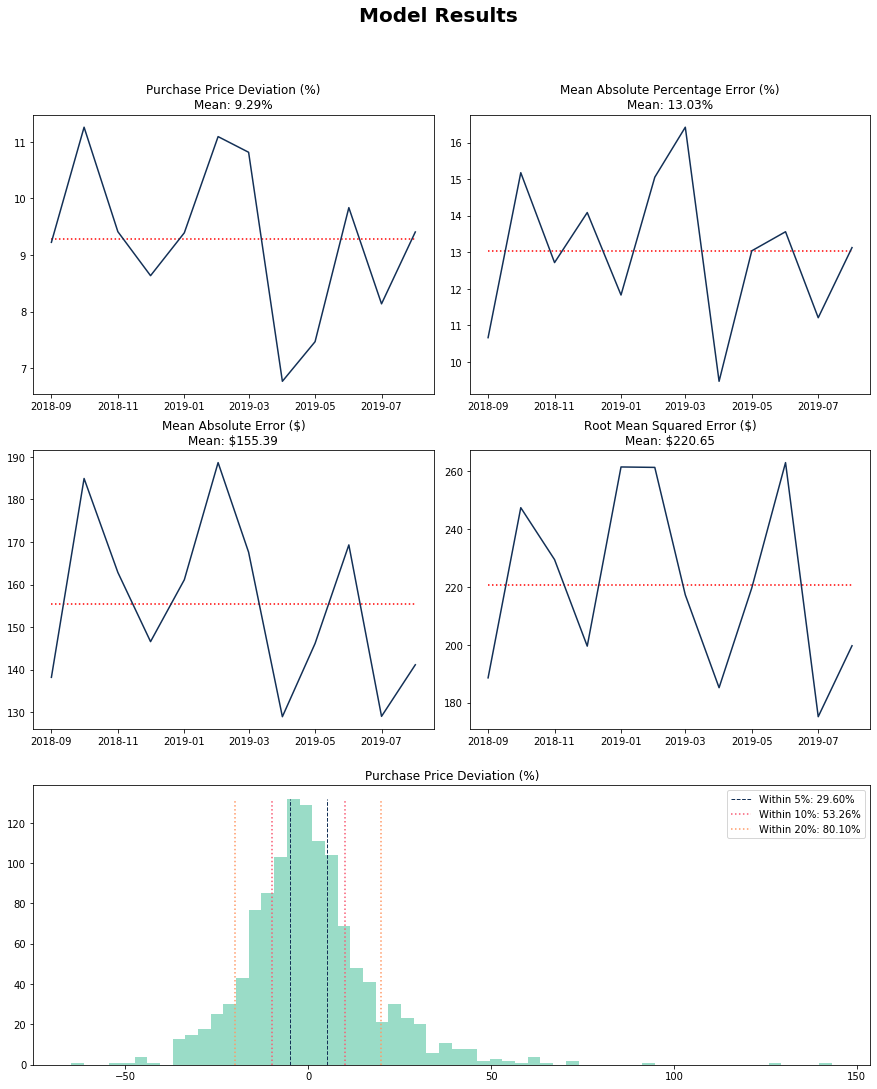

[MODEL STATISTICS]
M-PPD: 9.29%
PPD Deviation:
  +-5.0%: 29.47%
  +-10%: 53.28%
  +-20%: 79.54%

MAPE: 13.03%
MAE: $155
RMSE: $221
R2: 72.77%


In [19]:
lg = LGBMRegressor(n_estimators=1000, num_leaves=50, max_depth=10, random_state=123, n_jobs=4, reg_alpha=0.1, reg_lambda=0.9)
lg_cv = dns.custom_ts(rgr=lg, X=X_data, y=y_data, timevar='mth', start='2018-09-01', tfidf_cols=['project_name', 'street_name'], stop_words=stop_words, dropout=0.1, ppd=True, random_state=100)